# Исследование окупаемости рекламы развлекательного приложения Procrastinate Pro+

**Цель исследования:**

- определить, откуда приходят пользователи и какими устройствами они пользуются, сколько стоит привлечение пользователей из различных рекламных каналов;
- изучить динамику расходов на каждый источник и среднюю стоимость привлечения одного пользователя;
- построить графики  LTV, ROI и CAC общие и с разбивками по странам, устройствам, каналам привлечения;
- установить, какие факторы мешают привлечению клиентов.

**Ход исследования:**

Данные представленые в трех файлах /datasets/visits_info_short.csv, /datasets/orders_info_short.csv, /datasets/costs_info_short.csv. Перед началом анализа нужно будет провести их обзор.

- изучу и проведу предобработку данных (проверка на пропуски, дубликаты, тип данных)
- задам функции для расчета и анализа LTV, ROI, удержания и конверсии
- проведу исследовательский анализ: составлю профили пользователей и проанализирую их в разбивке по странам, устройствам и рекламным источникам
- изучу маркетинговую часть: динамику изменения расходов и среднюю стоимость привлечения одного пользователя
- оценю окупаемость рекламы с разбивкой и без с помощью графиков LTV, ROI, удержания и конверсии
- сделаю общий вывод и рекомендации для отдела маркетинга

### Загрузка данных и подготовка их к анализу

In [1]:
#импортирую нужные билблиотеки
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt

In [2]:
#загрузка данных

In [3]:
print(visits.info())
print('___________________')
print(orders.info())
print('___________________')
costs.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB
None
___________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB
None
___________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1

In [4]:
print(visits['Region'].value_counts())
print('___________________')
print(visits['Device'].value_counts()) 
print('___________________')
print(visits['Channel'].value_counts())
print('___________________')
print(costs['Channel'].value_counts()) 

United States    207327
UK                36419
France            35396
Germany           30759
Name: Region, dtype: int64
___________________
iPhone     112603
Android     72590
PC          62686
Mac         62022
Name: Device, dtype: int64
___________________
organic               107760
TipTop                 54794
FaceBoom               49022
WahooNetBanner         20465
LeapBob                17013
OppleCreativeMedia     16794
RocketSuperAds         12724
YRabbit                 9053
MediaTornado            8878
AdNonSense              6891
lambdaMediaAds          6507
Name: Channel, dtype: int64
___________________
MediaTornado          180
TipTop                180
FaceBoom              180
WahooNetBanner        180
YRabbit               180
LeapBob               180
RocketSuperAds        180
lambdaMediaAds        180
OppleCreativeMedia    180
AdNonSense            180
Name: Channel, dtype: int64


Ни в одной таблице нет пропусков и нет дубликатов. Приведу названия столбцов к хорошему тону, а все даты переведу в формат datetime.

In [5]:
#Привожу названия столбцов к нижнему регистру и заменяю пробел в названиях на нижнее подчеркивание.
visits.columns = visits.columns.str.lower().str.replace(" ", "_")
orders.columns = orders.columns.str.lower().str.replace(" ", "_")
costs.columns = costs.columns.str.lower().str.replace(" ", "_")

In [6]:
#изменяю в столбцах с датой и временем тип данных object на datetime
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
costs['dt'] = pd.to_datetime(costs['dt']).dt.date


In [7]:
#проверка на пропуски и дубликаты
print(visits.isna().sum())
visits.duplicated().sum()

user_id          0
region           0
device           0
channel          0
session_start    0
session_end      0
dtype: int64


0

In [8]:
print(orders.isna().sum())
orders.duplicated().sum()

user_id     0
event_dt    0
revenue     0
dtype: int64


0

In [9]:
print(costs.isna().sum())
costs.duplicated().sum()

dt         0
channel    0
costs      0
dtype: int64


0

In [10]:
#проверяю численные данные на наличие ошибок
print((orders['revenue'] <=0).sum())
(costs['costs'] <=0).sum()

0


0

count    40212.000000
mean         5.370608
std          3.454208
min          4.990000
25%          4.990000
50%          4.990000
75%          4.990000
max         49.990000
Name: revenue, dtype: float64


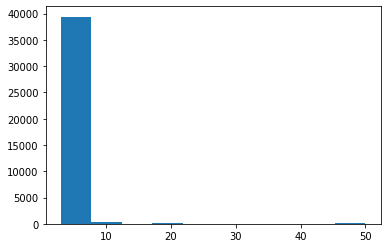

count    1800.000000
mean       58.609611
std       107.740223
min         0.800000
25%         6.495000
50%        12.285000
75%        33.600000
max       630.000000
Name: costs, dtype: float64


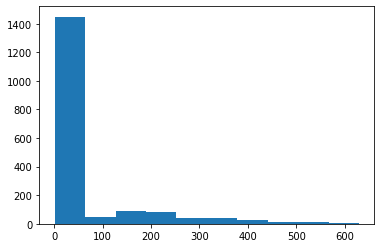

In [11]:
#роверяю численные данные на наличие аномалий и выбросов
print(orders['revenue'].describe())
plt.hist(orders['revenue'], range=(3,50))
plt.show()

print(costs['costs'].describe())
plt.hist(costs['costs'])
plt.show()


В столбце о сумме заказы наблюдаются несколько выбросов. Ниже посмотрю, сколько таких строк и решу, можно ли их удалить.
В столбце расходов на рекламу тоже значения сильно разбросаны, но таких данных много, поэтому здесь всё оставлю как есть.

In [12]:
#посчитаю сколько строк в сумме заказа находятся в выбросах
print((orders['revenue']>10).sum())

416



Количество таких строк составляет 1% от всех данных. Поэтому удалю их и оставлю стоимость заказов меньше 10 долларов.

In [13]:
orders = orders.query('revenue<10')

In [14]:
#проверю временной интервал сессии, чтобы окончание сессии не было раньше начала
(visits['session_end'] < visits['session_start']).sum()

0


    
Вывод о качестве исходных данных:
- нигде не наблюдаются пропуски и дубликаты, в численных данных нет ошибок 
- небольшие аномалии в сумме заказа были исключены
- заменила тип данных в столбцах с датой и временем для дальнейшего анализа с ними

### Функции для расчёта и анализа LTV, ROI, удержания и конверсии.


Для вычисления значений метрик:

- `get_profiles()` — для создания профилей пользователей,
- `get_retention()` — для подсчёта Retention Rate,
- `get_conversion()` — для подсчёта конверсии,
- `get_ltv()` — для подсчёта LTV.

Для построения графиков:

- `filter_data()` — для сглаживания данных,
- `plot_retention()` — для построения графика Retention Rate,
- `plot_conversion()` — для построения графика конверсии,
- `plot_ltv_roi` — для визуализации LTV и ROI.

In [15]:
# функция для создания пользовательских профилей

def get_profiles(sessions, orders, ad_costs):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

In [16]:
# функция для расчёта удержания

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

In [17]:
# функция для расчёта конверсии

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

In [18]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    ) 

In [19]:
# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 

In [20]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show() 

In [21]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

In [22]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

### Исследовательский анализ данных



#### Составление профилей

In [23]:
profiles = get_profiles(visits, orders, costs)
profiles.head(5)

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


Установлю момент и горизонт анализа. 

In [24]:
observation_date = profiles['dt'].max()  # момент анализа
horizon_days = 14 # горизонт анализа 
observation_date

datetime.date(2019, 10, 27)

Моментом анализа является 27 октября 2019г, горизонт анализа - 14 дней (по данным из задания).

In [25]:
min_date = profiles['dt'].min() 
min_date

datetime.date(2019, 5, 1)


Минимальная и максимальная даты совпадают с условиями ТЗ - рассматриваем период с 1 мая 2019г по 27 октября 2019г.

#### Анализ стран пользователей

In [26]:
profiles['region'].unique()

array(['United States', 'France', 'Germany', 'UK'], dtype=object)

In [27]:
country = (
    profiles.groupby('region').agg({'user_id' : 'count', 'payer' : 'sum'}).reset_index()
)
country['share'] = (country['payer']/ country['user_id']).apply('{:.1%}'.format)
country.sort_values(by='share', ascending=False)

,region,user_id,payer,share
3,United States,100002,6863,6.9%
1,Germany,14981,616,4.1%
2,UK,17575,698,4.0%
0,France,17450,661,3.8%


Больше всего пользователей приложения из США. Также в США и большая доля платящих пользователей по сравнению с другими странами - 6,9%. В Великобритании, Франции и Германии примерно одинаковое значение доли платящих - 4%.

#### Анализ устройств

In [28]:
profiles['device'].unique()

array(['Mac', 'iPhone', 'PC', 'Android'], dtype=object)

In [29]:
device = (
    profiles.groupby('device').agg({'user_id' : 'count', 'payer' : 'sum'}).reset_index()
)
device['share'] = (device['payer']/ device['user_id']).apply('{:.1%}'.format)
device.sort_values(by='share', ascending=False)

,device,user_id,payer,share
1,Mac,30042,1903,6.3%
3,iPhone,54479,3360,6.2%
0,Android,35032,2043,5.8%
2,PC,30455,1532,5.0%


Приложением пользуются пользователи устройств: Mac, iPhone, Android и PC.
Общее количество пользователей и количество платящих больше всего на устройствах iPhone. Однако наибольшая доля платящих приходится на пользователей с устройств Mac - 6,4%, пользователи iPhone немного уступают - 6,2%.

#### Анализ рекламных источников привлечения

In [30]:
channel = (
    profiles.groupby('channel').agg({'user_id':'count', 'payer':'sum'}).reset_index()
)
channel['share'] = channel['payer'] / channel['user_id']
channel = channel.sort_values(by='share', ascending=False)
channel['share'] = channel['share'].apply('{:.1%}'.format)
channel

,channel,user_id,payer,share
1,FaceBoom,29144,3522,12.1%
0,AdNonSense,3880,436,11.2%
9,lambdaMediaAds,2149,225,10.5%
6,TipTop,19561,1876,9.6%
5,RocketSuperAds,4448,352,7.9%
7,WahooNetBanner,8553,453,5.3%
8,YRabbit,4312,165,3.8%
3,MediaTornado,4364,156,3.6%
2,LeapBob,8553,262,3.1%
4,OppleCreativeMedia,8605,233,2.7%


Самым эффективным каналом привлечения платящих пользователей является FaceBoom с долей платящих - 12,2%. 

В целом можно выделить 5 наиболее эффективных каналов: 
- FaceBoom - 12,2%,
- AdNonSense - 11,3%, 
- lambdaMediaAds - 10,5%, 
- TipTop - 9,6%, 
- RocketSuperAds - 7,9%.

Следует отметить, что органический трафик имеет наименьшую долю платящих пользователей - 2,1%.

Получается, что больше всего приходит пользователей из США и они лучше других конвертируется. При этом большая часть пользователей заходит с мобильных устройств, это тоже стоит отметить. Также, мы можем сказать, что наибольшую конверсию имеют пользователи, которые пользуются Mac, а затем следуют пользователи iPhone, т.е. мы можем сказать, что в целом пользователи Apple имеют лучшую конверсию в покупателей. Возможно, тут есть плюсы ApplePay.

### Маркетинг



In [31]:
round(costs['costs'].sum(), 1)

105497.3

In [32]:
costs.groupby('channel').agg({'costs': 'sum'}).reset_index().sort_values(by = 'costs', ascending=False)

,channel,costs
6,TipTop,54751.30
1,FaceBoom,32445.60
7,WahooNetBanner,5151.00
0,AdNonSense,3911.25
4,OppleCreativeMedia,2151.25
5,RocketSuperAds,1833.00
2,LeapBob,1797.60
9,lambdaMediaAds,1557.60
3,MediaTornado,954.48
8,YRabbit,944.22


#### Динамика изменения расходов во времени по каждому источнику

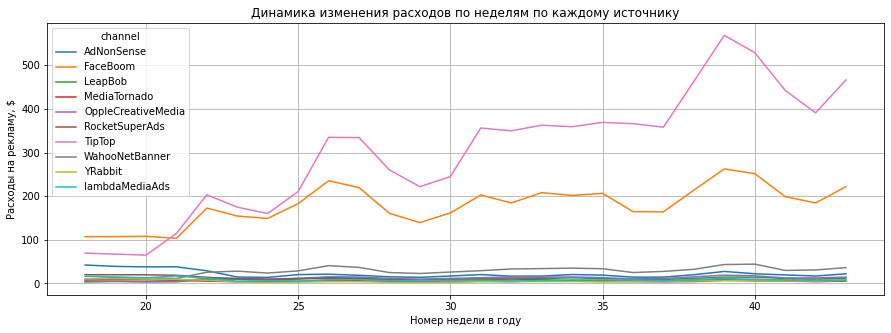

In [34]:
costs['dt'] = pd.to_datetime(costs['dt'])
costs['week'] = costs['dt'].dt.isocalendar().week
costs['month'] = pd.DatetimeIndex(costs['dt']).month

costs_channel = costs.pivot_table(
    index= 'week', columns = 'channel', values = 'costs'
)
costs_channel.plot(grid=True, figsize=(15, 5))
plt.title('Динамика изменения расходов по неделям по каждому источнику')
plt.xlabel('Номер недели в году')  
plt.ylabel('Расходы на рекламу, $')  
plt.show()

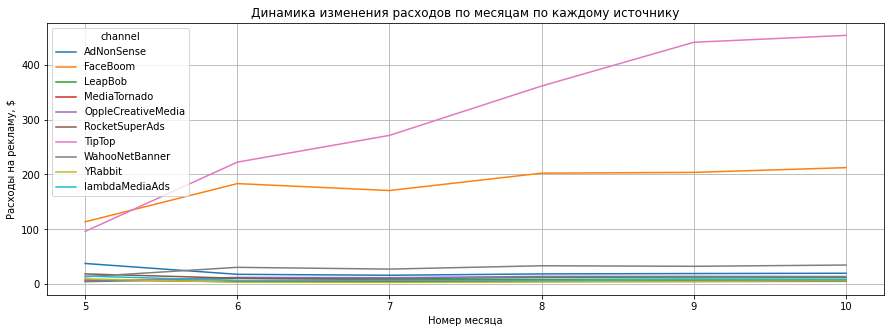

In [35]:
costs['dt'] = pd.to_datetime(costs['dt'])
costs['week'] = costs['dt'].dt.isocalendar().week
costs['month'] = pd.DatetimeIndex(costs['dt']).month

costs_channel = costs.pivot_table(
    index= 'month', columns = 'channel', values = 'costs'
)
costs_channel.plot(grid=True, figsize=(15, 5))
plt.title('Динамика изменения расходов по месяцам по каждому источнику')
plt.xlabel('Номер месяца')  
plt.ylabel('Расходы на рекламу, $') 
plt.show()

По таблице и графику видно, что есть два явных лидера по каналам привлечения, куда вложено более 80% от всего бюджета. Это каналы TipTop - 54751, FaceBoom 32445$ за весь период анализа.

Для канала TipTop наблюдается следующая заивисмость - с каждым месяцем расходы на рекламу увеличиваются, а в сентябре достигло пика - более 500$ в неделю, а далее бюджет постепенно начал уменьшаться до 400-450.

В FaceBoom уровень бюджета на рекламу примерно в одном диапазоне - 200$ в неделю.

В остальных каналах бюджет на привлечение пользователей примерно на одном уровне - до 40$ в неделю.

#### Средняя стоимость привлечения одного пользователя из каждого источника

In [36]:
cac_channel = profiles.groupby('channel').agg({'acquisition_cost':'mean'}).reset_index().sort_values(by='acquisition_cost', ascending=False)
print(cac_channel)
print()
print('Средний САС =', round(cac_channel['acquisition_cost'].mean(), 2))

               channel  acquisition_cost
6               TipTop          2.799003
1             FaceBoom          1.113286
0           AdNonSense          1.008054
9       lambdaMediaAds          0.724802
7       WahooNetBanner          0.602245
5       RocketSuperAds          0.412095
4   OppleCreativeMedia          0.250000
8              YRabbit          0.218975
3         MediaTornado          0.218717
2              LeapBob          0.210172
10             organic          0.000000

Средний САС = 0.69


Наиболее дорогостоящим каналом привлечения пользователей является TipTop, однако количество и доля платящих пользователей, приходящих с этого источника, не так высоки. Это можно объяснить молодой аудиторией TipTop'a и, соответственно, не очень высокой их платежеспособностью.
    

Самый дорогой пользователь из канала привлечения TipTop - 2,8 доллара. 
Из FaceBoom и AdNonSense стоимость привлечения пользователя в 2,5 раза меньше.
В остальных рекламных каналах от 0,2 до 0,7$.

### Оценка окупаемости рекламы



#### Анализ окупаемости рекламы

In [37]:
profiles = profiles.query('channel != "organic"')

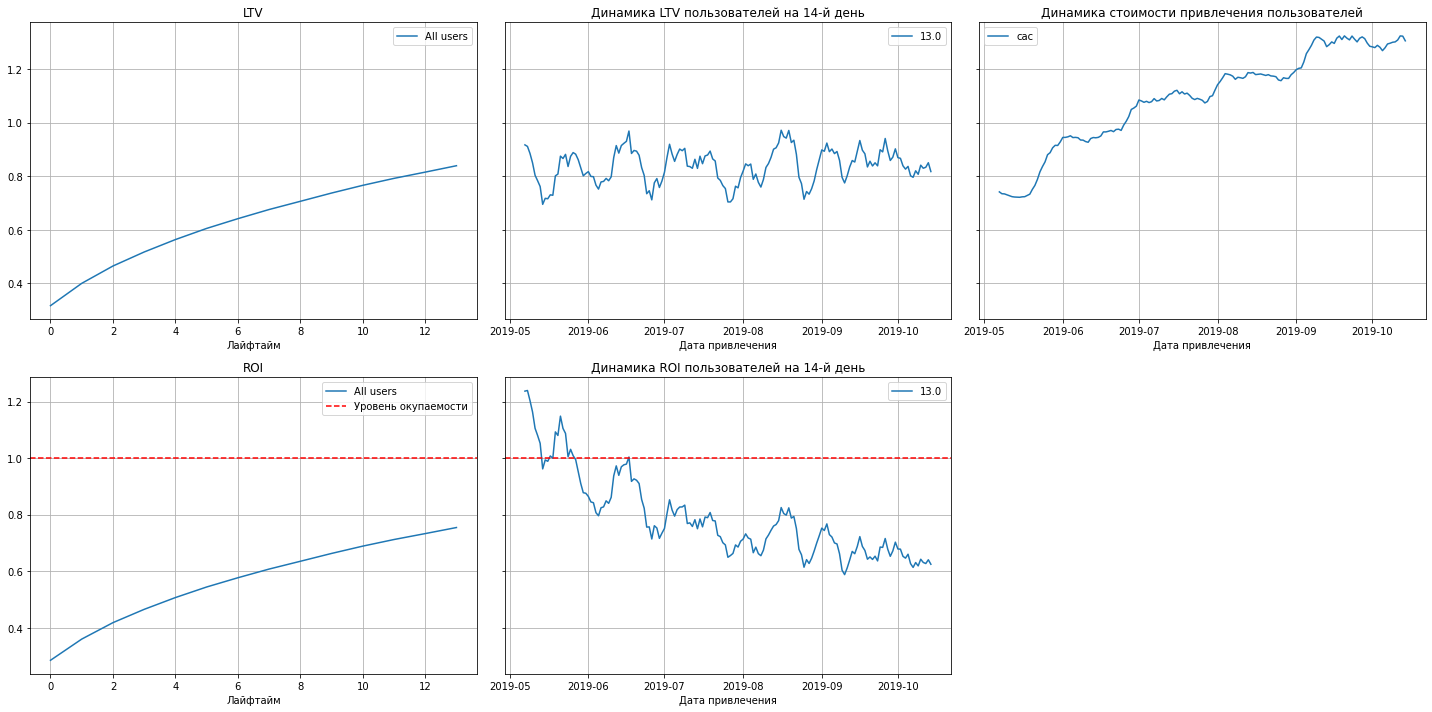

In [38]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days
)

plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 



По графикам можно сделать такие выводы:
- С конца мая реклама перестала окупаться. ROI в конце второй недели ниже 80%.
- CAC увеличивается с каждым месяцем. Резкий скачок роста был во второй половине мая. Это связано с увеличением рекламного бюджета в двух каналах продвижения TipTop и FaceBoom, об этом говорит график из предыдущего пункта - Динамика изменения расходов во времени по каждому источнику.
- LTV достаточно стабилен. Значит, дело не в ухудшении качества пользователей.

#### Конверсия и удержание пользователей и динамика их изменения

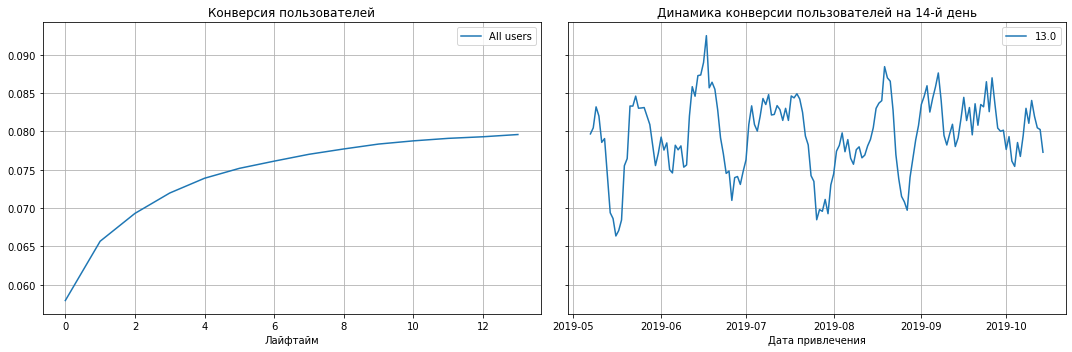

In [39]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

Судя по графикам, конверсия пользователей постепенно растет.

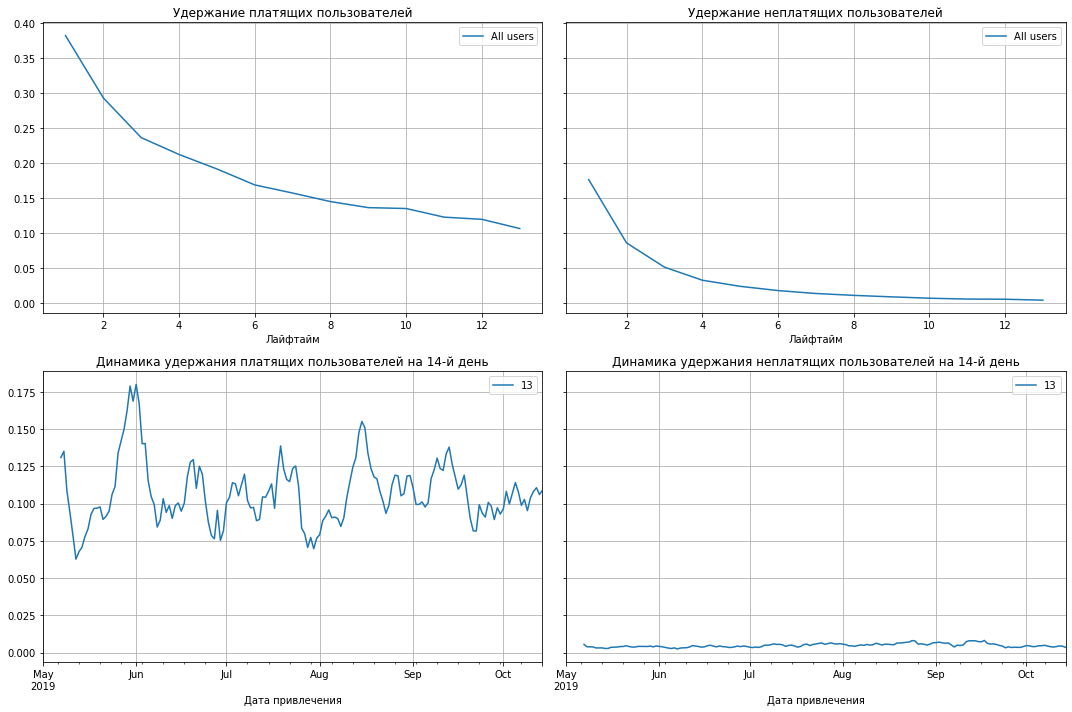

In [40]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days
)

plot_retention(retention_grouped, retention_history, horizon_days) 

Удержание и платящих, и неплатящих пользователей заметно снижается к концу второй недели - более чем 70%.
Динамика удержания всех пользователей стабильна, но у платящих гораздо больше.

#### Анализ окупаемости рекламы с разбивкой по устройствам

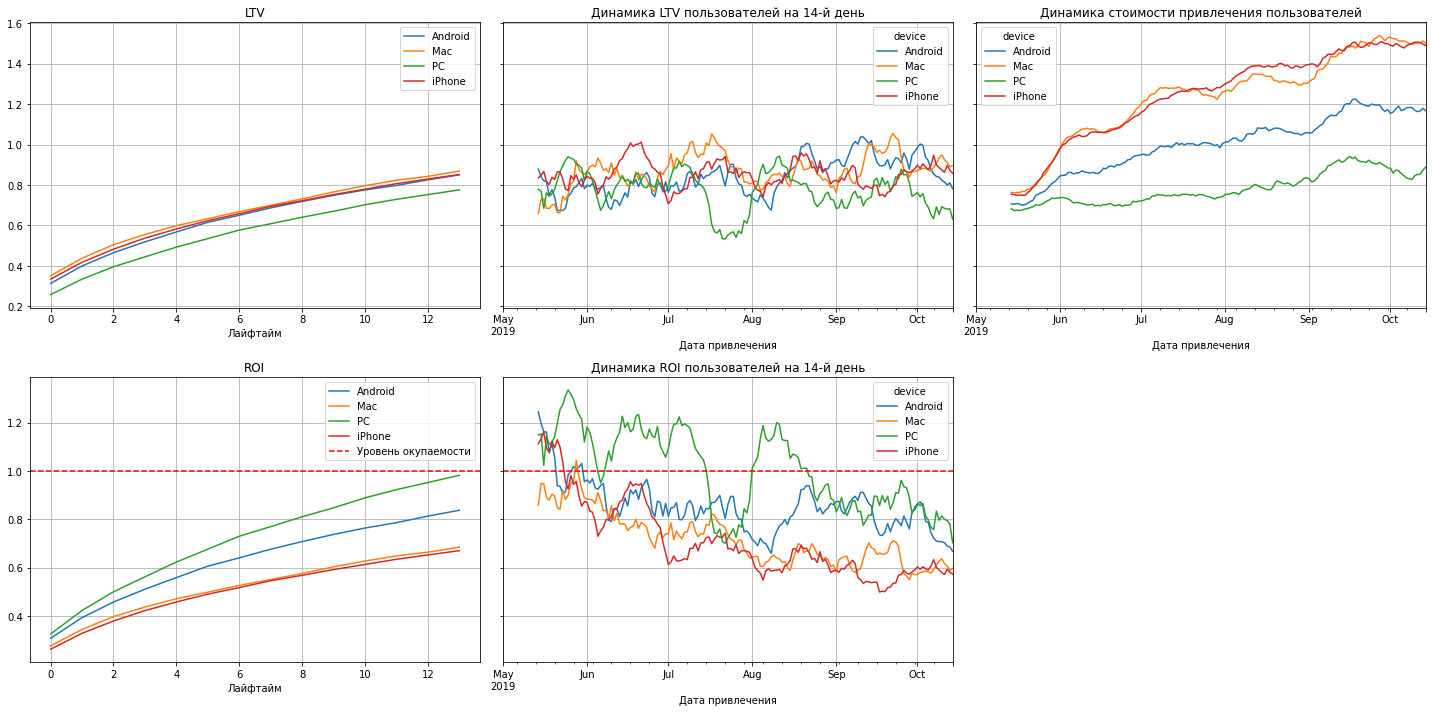

In [41]:
dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

- Реклама не окупается ни на одном устройстве
- Стоимость привлечения пользователей растет на всех устройствах, но наиболее выраженный рост у пользователей Mac и iPhone 
- Самый дешевый пользователь идет с устройств PC, там же ROI стремится к уровню окупаемости рекламы (выше остальных)

#### Анализ окупаемости рекламы с разбивкой по странам

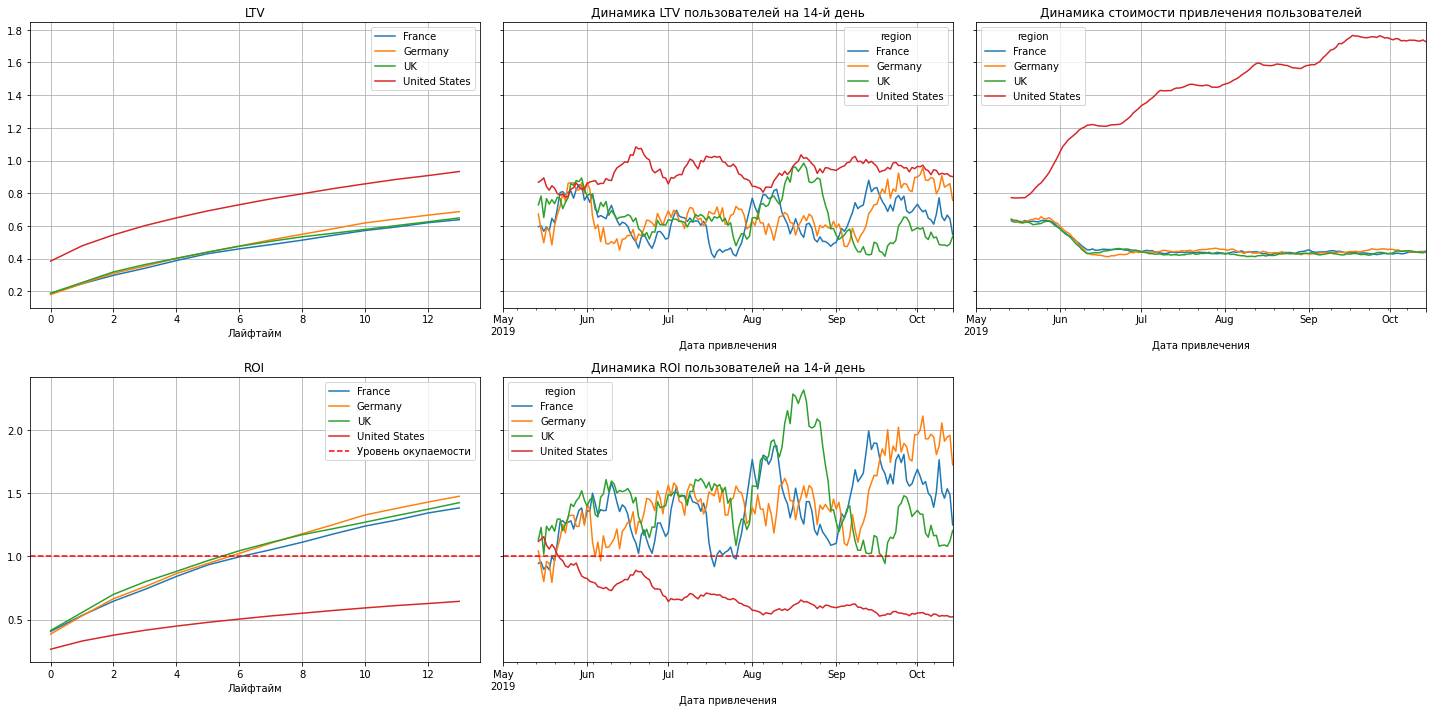

In [42]:
dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

По графикам виделяются пользователи из США:
- реклама с пользователей, привлеченных с середины мая, перестала окупаться
- стоимость привлечения данных пользователей резко увеличилась и почти в 4 раза больше стоимости из других стран
- при этом LTV пользователей из США выше всех остальных

#### Анализ окупаемости рекламы с разбивкой по каналам привлечения

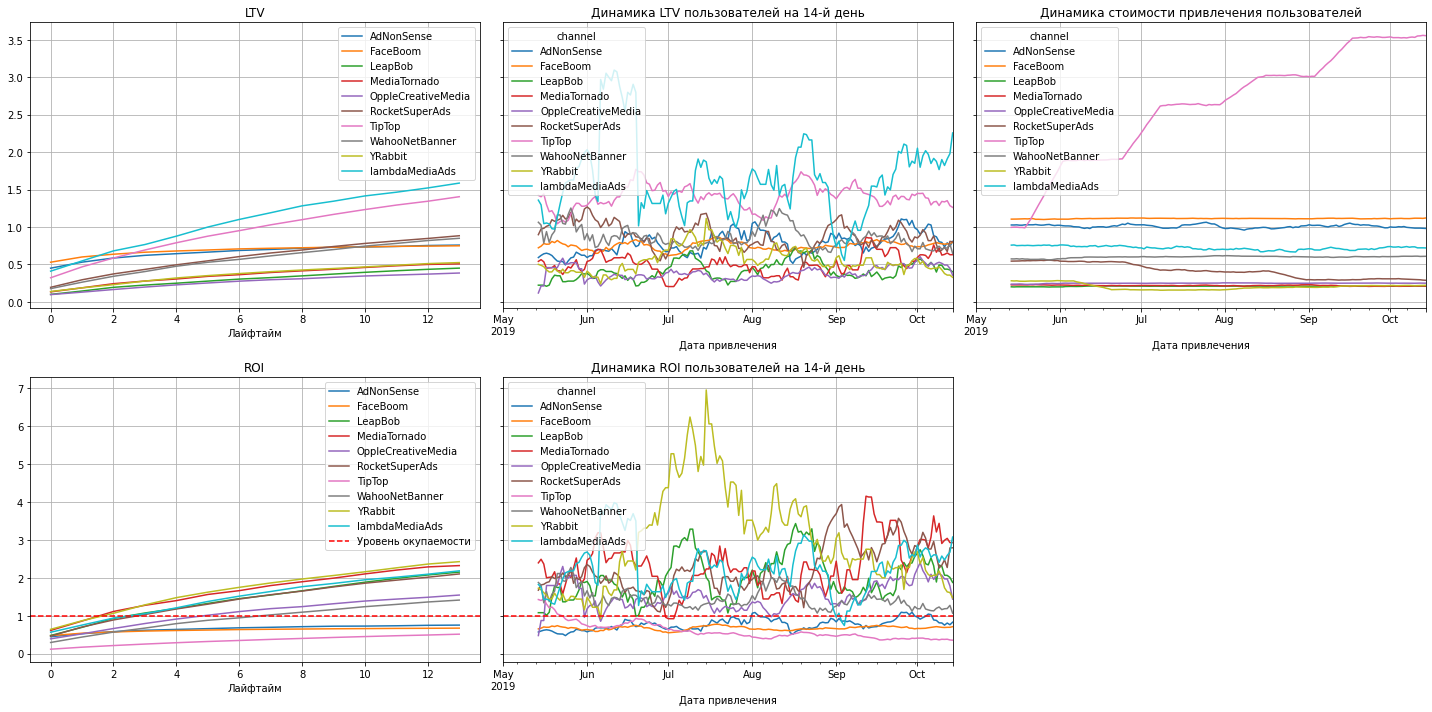

In [43]:
dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 


- Три рекламные площадки стабильно не окупаются TipTop, FaceBoom, AdNonSense, при этом на эти площадки выделяется наибольшее количество средств
- На TipTop резко и стабильно растет стоимость привлечения пользователей.

Посмотрю, в чем причина: в низкой конверсии или низком удержании.

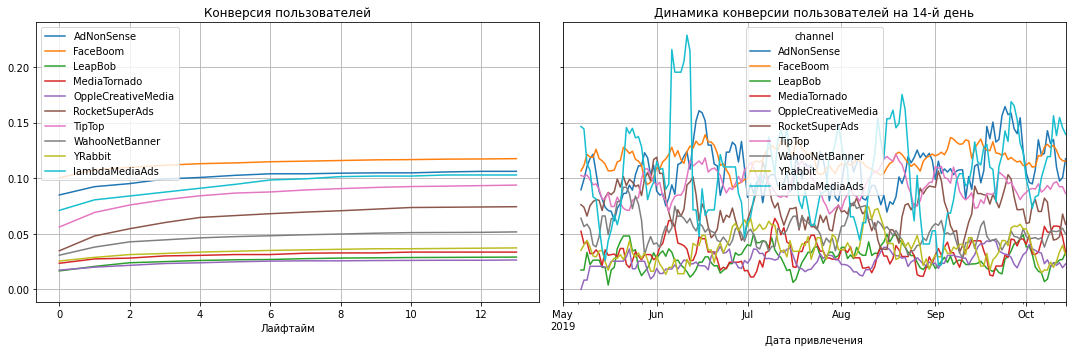

In [44]:
dimensions = ['channel']
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

Судя по графикам, пользователи из FaceBoom, AdNonSense, lambdaMediaAds, TipTop конвертируеются хорошо. Проверю удержание.

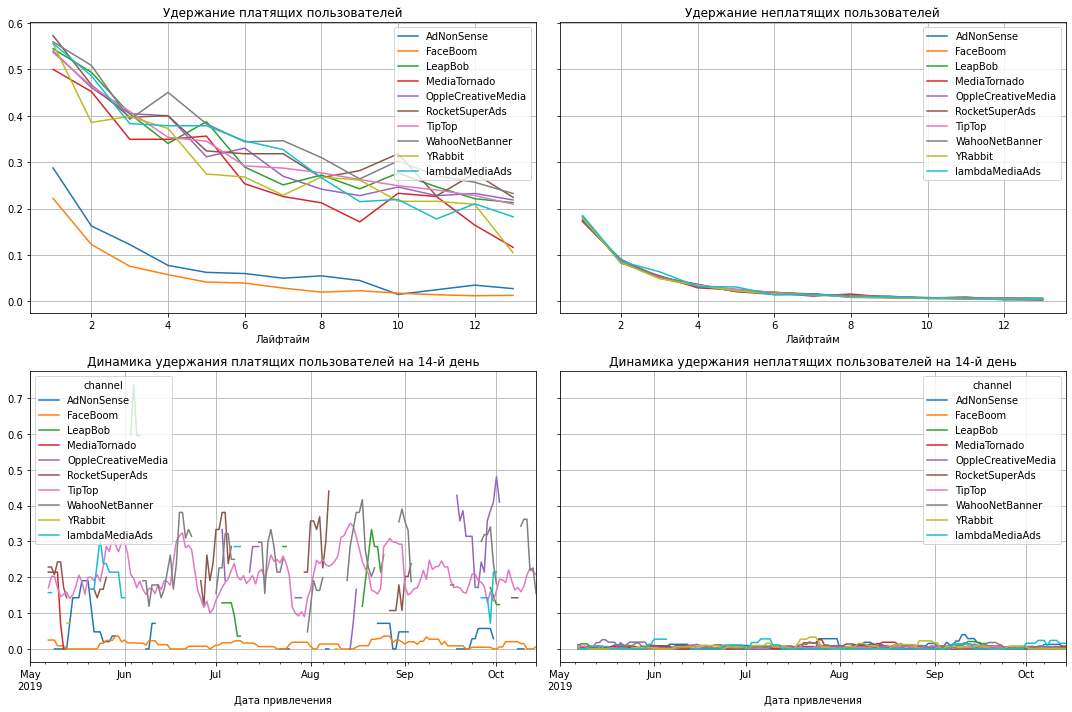

In [45]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

В целом на всех рекламных каналах удержание пользователей заметно снижается и, скорее всего, не все проходят все 14 дней (судя по прерывистым графикам). Особенно низкие показатели у рекламных каналов - FaceBoom и AdNonSense. А динамика удержания пользователей на 14й день у FaceBoom близка к нулю.

Посмотрю конверсию и динамику удержания по странам.

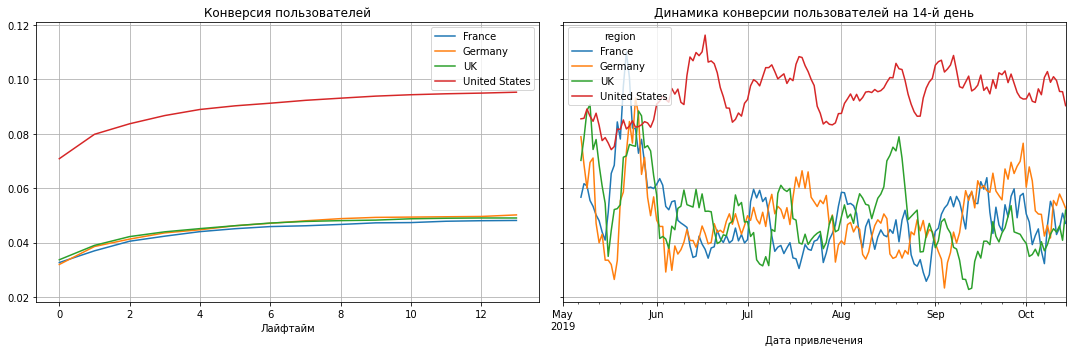

In [46]:
dimensions = ['region']
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

Лучше всего конвертируеются пользователи из США - конверсия в 2 раза выше других стран.

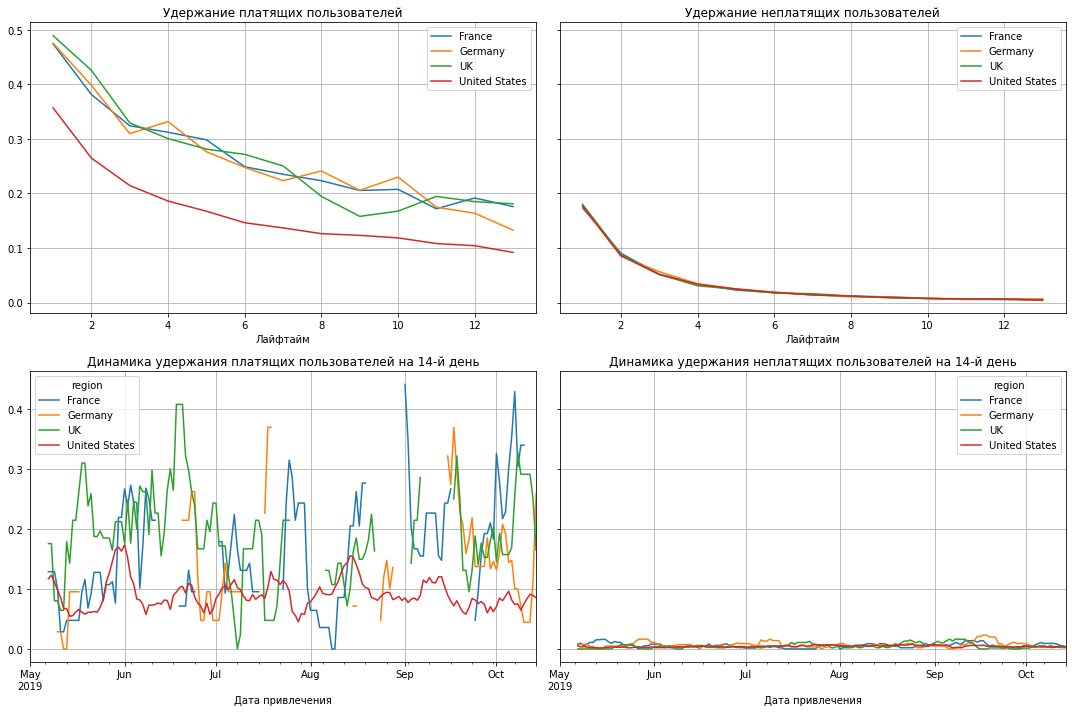

In [47]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

А вот удерживаются пользователи из США хуже остальных.

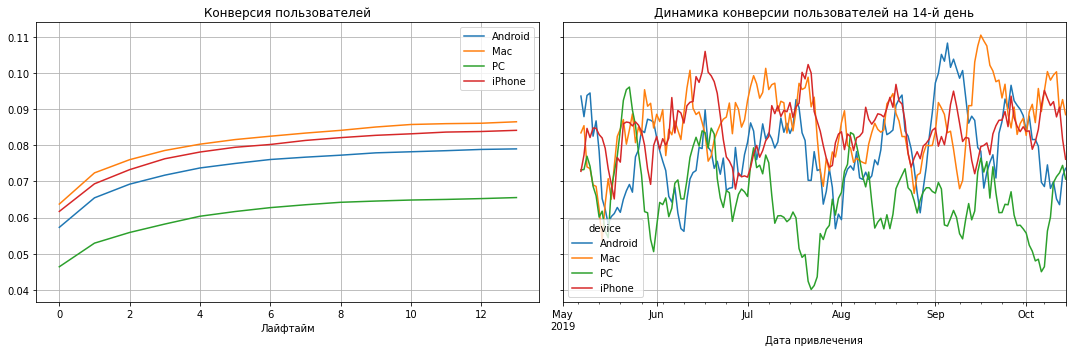

In [48]:
dimensions = ['device']
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

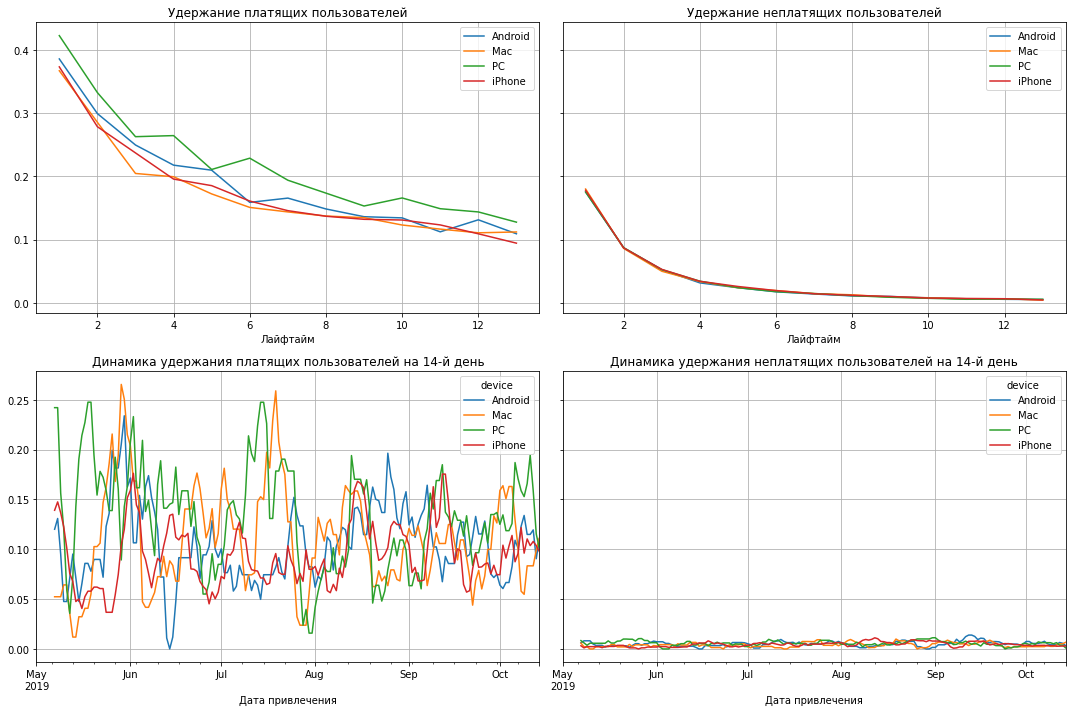

In [49]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

По данным графикам можно сделать вывод, что удержание пользователей на всех устройствах примерно одинаковое. А конверсия лучше всего идет с iPhone и Mac.

По разделу изучения окупаемости рекламы сделаны следующие выводы:

- реклама на привлечение пользователей не окупается
- на окупаемость рекламы негативно сказываются:
    - пользователи из США
    - рекламные площадки TipTop, FaceBoom, AdNonSense

Проблемы окупаемости в основном связаны с низким удержанием пользователей из США и рекламных каналов FaceBoom и AdNonSense.

Рекомендации для рекламного отдела:
- подробнее изучить, исправить (или исключить) из рекламы - рекламные площадки TipTop, FaceBoom, AdNonSense, особое внимание обратить на TipTop, так как у нее наблюдается постоянный рост стоимости привлечения пользователей
- подробнее изучить, исправить рекламу на пользователей из США. В ней реклама не окупается и стоимость привлечения пользователей в 4 раза выше остальных. Хотя больше всего платящих пользователей здесь.
- наиболее эффективные площадки, куда можно увеличить бюджет - YRabbit, lambdaMediaAds, RocketSuperAds, MediaTornado, LeapBob

### Выводы



Причины неэффективности привлечения пользователей:
- реклама не окупается
- с увеличением рекламного бюджета увеличилась стоимость привлечения пользователей, и реклама перестала окупаться
- неудачно выбраны рекламные площадки для выделения на них максимального бюджета TipTop, FaceBoom, AdNonSense
- на окупаемость рекламы негативно сказываются:
    - пользователи из США: низкое удержание, но высокая конверсия
    - рекламные площадки TipTop, FaceBoom, AdNonSense: низкое удержание, но высокая конверсия


Рекомендации для отдела маркетинга:
- обратить внимание на низкое удержание пользователей, возможные обновления, изменения в приложении, ошибки
- TipTop, FaceBoom, AdNonSense - неокупаемые рекламные площадки при максимальном на них распределении от всего бюджета
- особое внимание обратить на  TipTop, так как у нее наблюдается постоянный рост стоимости привлечения пользователей
- подробнее изучить, исправить рекламу на пользователей из США. В ней реклама не окупается и стоимость привлечения пользователей в 4 раза выше остальных. Хотя больше всего платящих пользователей здесь
- наибольшее число пользователей приходится на мобильные устройства, а наибольшая конверсия с устройств Mac и iPhone
- наиболее эффективные площадки, куда можно увеличить бюджет - lambdaMediaAds, RocketSuperAds. У них наибольшая доля платящих пользователей и при этом реклама стабильно окупается